In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

# EDA

## Seller profitability by order value

In [2]:
sellers = pd.read_csv('./brazilian-ecommerce/olist_sellers_dataset.csv', index_col=0)
order_items = pd.read_csv('./brazilian-ecommerce/olist_order_items_dataset.csv')
orders = pd.read_csv('./brazilian-ecommerce/olist_orders_dataset.csv')

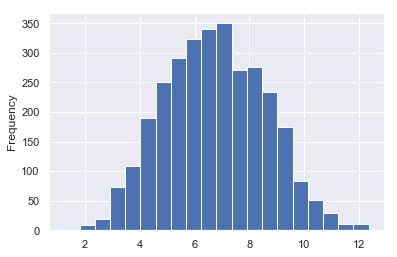

In [71]:
sellers.merge(order_items.groupby('seller_id')[['price', 'freight_value']].sum(),
              'left', left_index=True, right_index=True)\
        .sort_values(by='price', ascending=False)\
        .loc[:,'price']\
        .apply(np.log)\
        .plot.hist(bins=20);

Merchant revenue approx. follows a lognormal distribution

## Seller popularity by order volume

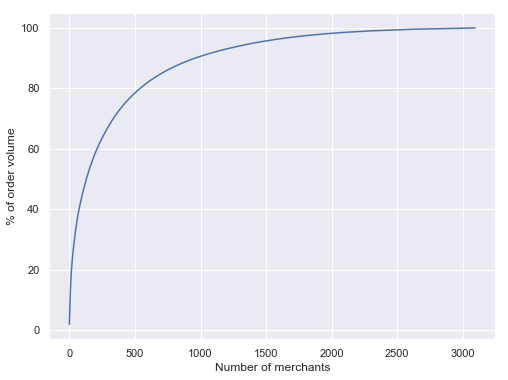

In [266]:
order_items['seller_id'].value_counts(normalize=True).cumsum()\
                        .apply(lambda x: x * 100)\
                        .reset_index(drop=True).plot.line(figsize=(8,6));
plt.ylabel("% of order volume")
plt.xlabel("Number of merchants");

## Map to Lat Long for Tableau

In [54]:
geoloc = pd.read_csv('./brazilian-ecommerce/olist_geolocation_dataset.csv', usecols=[0,1,2])
geoloc['geolocation_zip_code_prefix'] = geoloc['geolocation_zip_code_prefix'].astype(int)

In [30]:
sellers = sellers.set_index('seller_id')
sellers['order_vol'] = order_items['seller_id'].value_counts()

In [41]:
sellers = sellers.merge(order_items.groupby('seller_id')[['price', 'freight_value']].sum(),
                        'left', left_index=True, right_index=True)

In [68]:
pd.merge(sellers.reset_index(), geoloc.groupby('geolocation_zip_code_prefix').mean(),
         how='left', left_on='seller_zip_code_prefix', right_index=True).to_csv('merchant_value_coords.csv')

# Build targeting models using features created from merchant behavior

Dependent variables: 
* Churn
  * Hazard model with age of merchant in months as hazard dependent variable
  * Features to use are revenue, biz segment, lead_type, lead_behavior_profile, biz type, review rating, maybe city?
* Value/Revenue
  * Linear Regression, with log transform on mean monthly revenue
  * Features to use are category, num_prods, price, payment terms, reviews, maybe city?

In [39]:
sellers = pd.read_csv('./brazilian-ecommerce/olist_sellers_dataset.csv', index_col=0)
order_items = pd.read_csv('./brazilian-ecommerce/olist_order_items_dataset.csv')
orders = pd.read_csv('./brazilian-ecommerce/olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp'])
prods = pd.read_csv('./brazilian-ecommerce/olist_products_dataset.csv')
cats = pd.read_csv('./brazilian-ecommerce/product_category_name_translation.csv')
reviews = pd.read_csv('./brazilian-ecommerce/olist_order_reviews_dataset.csv')
payments = pd.read_csv('./brazilian-ecommerce/olist_order_payments_dataset.csv')

## Churn

In [14]:
# join product category, reviews, payments and orders to order_items
merchant = order_items.merge(prods.merge(cats, how='left', on='product_category_name')\
                                  .loc[:,['product_id', 'product_category_name_english']],
                             how='left', on='product_id')\
                      .merge(reviews[['order_id', 'review_score']],
                             how='left', on='order_id')\
                      .merge(payments[['order_id', 'payment_type', 'payment_installments']],
                             how='left', on='order_id')\
                      .merge(orders[['order_id', 'order_purchase_timestamp']],
                             how='left', on='order_id')

In [15]:
# remove unnecessary columns
merchant.drop(columns=['order_id', 'order_item_id', 'product_id', 'shipping_limit_date'],
              inplace=True)

In [11]:
# merchant.to_csv('merchant_churn.csv')

In [17]:
# fill NA in product category
merchant.product_category_name_english.fillna('NA_category',
                                              inplace=True)

In [29]:
# compute merchant level attributes for churn model
temp = merchant.groupby('seller_id').agg({'price': lambda x: np.mean(np.log(x)),
                                          'freight_value': np.median,
                                          'product_category_name_english': lambda x: list(set(x)),
                                          'review_score': np.mean,
                                          'payment_type': lambda x: list(set(x)),
                                          'payment_installments': np.mean,
                                          'order_purchase_timestamp': [np.max, np.min]})
# rename columns to be more verbose
temp.columns = temp.columns.map('_'.join)
temp.rename(columns={'payment_type_<lambda>': 'payment_type',
                     'order_purchase_timestamp_amax': 'last_order_timestamp',
                     'order_purchase_timestamp_amin': 'first_order_timestamp',
                     'review_score_mean': 'mean_review_score',
                     'payment_installments_mean': 'mean_installments',
                     'product_category_name_english_<lambda>': 'product_category',
                     'price_<lambda>': 'mean_log_price',
                     'freight_value_median': 'median_freight'},
            inplace=True)

In [30]:
# convert payment types to dummies
payment_dummies = pd.get_dummies(temp.payment_type.apply(pd.Series).stack()).sum(level=0)\
                    .rename(columns=lambda x: 'payment_type_'+x)

# take top 10 product categories, concat the rest as 'others'
top_categories = temp.product_category.apply(pd.Series).stack()\
                                      .value_counts()[:10]\
                                      .index.tolist()
category_dummies = pd.get_dummies(temp.product_category.apply(pd.Series).stack())\
                     .sum(level=0) # convert series of list of series of series
category_dummies['others'] = category_dummies.loc[:,~category_dummies.columns.isin(top_categories)]\
                                             .max(axis=1) # assign non-top-categories to 'others'
category_dummies = category_dummies[top_categories + ['others']]

In [31]:
# add dummy variables back to temp table
temp =  temp.merge(payment_dummies, how='inner', left_index=True, right_index=True)\
            .merge(category_dummies, how='inner', left_index=True, right_index=True)\
            .drop(columns=['payment_type', 'product_category'])
# Use Date instead of DateTime values, for simplicity in R
temp['last_order_timestamp'] = temp['last_order_timestamp'].dt.date
temp['first_order_timestamp'] = temp['first_order_timestamp'].dt.date

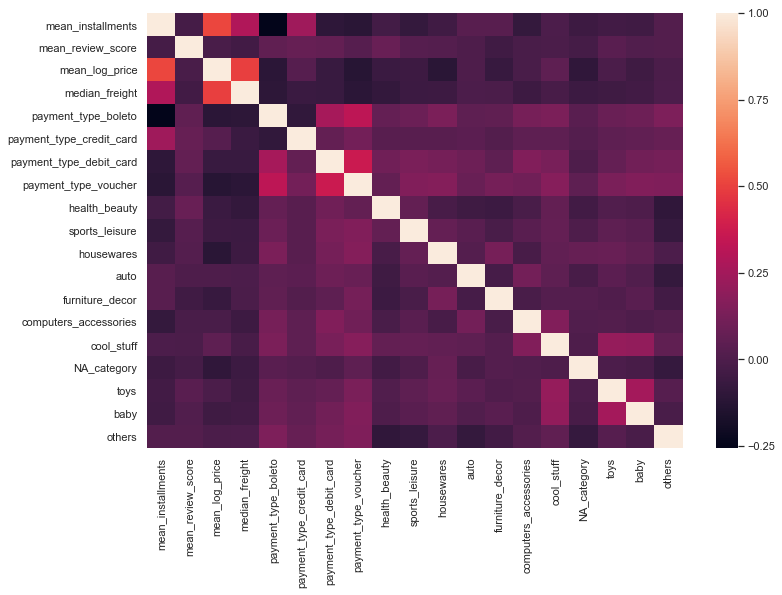

In [34]:
plt.figure(figsize=(12,8))
sns.heatmap(temp.corr());

Save to CSV file for R survival analysis.

In [143]:
# temp.to_csv('merchant_preprocessed.csv')

Read in predicted churn rates from R survival's Weibull AFT model

In [35]:
churn = pd.read_csv('./predicted_churn_weeks.csv', index_col=0)

In [36]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2950 entries, 0015a82c2db000af6aaaf3ae2ecb0532 to fffd5413c0700ac820c7069d66d98c89
Data columns (total 3 columns):
fitted         2950 non-null float64
quantile_10    2950 non-null float64
quantile_90    2950 non-null float64
dtypes: float64(3)
memory usage: 92.2+ KB


## Expected revenue (CLV)

$$CLV=\sum_{t=0}^T{\frac{mr^t}{(1+d)^t}} - AC$$ i.e. CLV model 2

**Assumptions:**
* Annual discount rate of 20% (aggressive cost of capital)
* Commission to platform is 10% of merchant's revenue
* Use Weekly values

In [143]:
CLV = order_items.merge(orders[['order_id', 'order_purchase_timestamp']],
                                how='left', on='order_id')\
                 .groupby('seller_id')\
                 .agg({'price': lambda x: np.sum(x),
                       'order_purchase_timestamp': lambda x: np.max(x)-np.min(x)})
# rename columns and preprocess to weekly values
CLV.rename(columns={'price': 'total_revenue',
                    'order_purchase_timestamp': 'timespan'},
           inplace=True)
CLV['timespan'] = CLV.timespan.dt.days / 7 + 1
CLV['avg_weekly_revenue'] = CLV.total_revenue / CLV.timespan

# join with churn data, 145 sellers were dropped due to left censorship
CLV = CLV.merge(churn, how='inner', left_index=True, right_index=True)

In [144]:
# constants
annual_disc = 0.2
commission = 0.1

In [145]:
wkly_disc = (1+annual_disc)**(1/52)
# discount number of weeks in lifetime by discount factor
CLV['pv_factor'] = CLV.fitted.apply(lambda x: sum(1/wkly_disc**t for t in range(int(x)+1)))
CLV['clv'] = CLV.avg_weekly_revenue * commission * CLV.pv_factor

In [146]:
CLV.head()

,timespan,total_revenue,avg_weekly_revenue,fitted,quantile_10,quantile_90,pv_factor,clv
seller_id,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,4.000000,2685.00,671.250000,16.426616,1.485884,40.023415,16.532223,1109.725473
001cca7ae9ae17fb1caed9dfb1094831,75.714286,25080.03,331.245679,578.037344,52.286867,1408.386729,248.189727,8221.177471
001e6ad469a905060d959994f1b41e4f,1.000000,250.00,250.000000,3.773009,0.341291,9.192928,3.979049,99.476217
002100f778ceb8431b7a1020ff7ab48f,31.000000,1234.50,39.822581,102.393612,9.262103,249.481813,86.603599,344.877880
003554e2dce176b5555353e4f3555ac8,1.000000,120.00,120.000000,5.290580,0.478564,12.890486,5.947744,71.372924


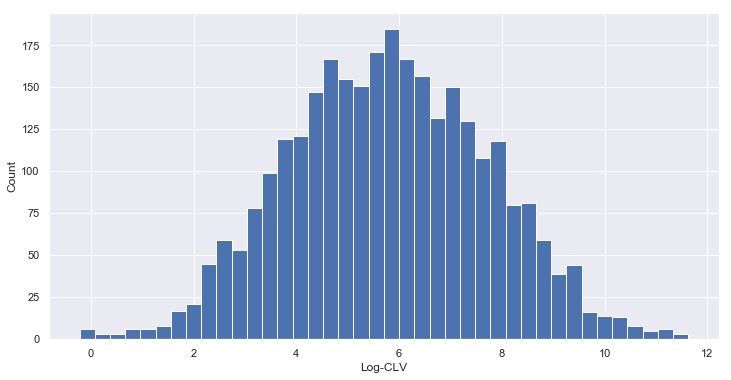

In [147]:
CLV.clv.apply(np.log).hist(bins=40, figsize=(12,6)) # log distribution is preserved
plt.xlabel('Log-CLV')
plt.ylabel('Count');

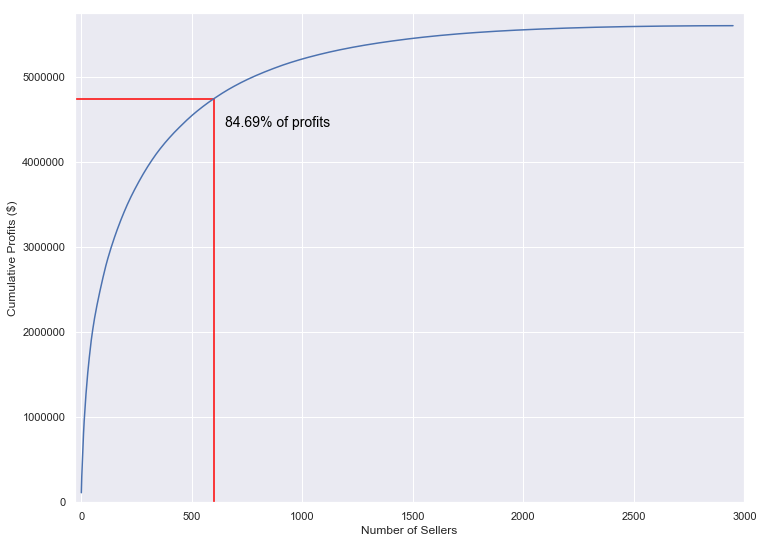

In [148]:
# cumulative value plot (stobachoff curve of profits)
CLV.sort_values(by='clv', ascending=False)\
    .clv.cumsum()\
    .reset_index(drop=True)\
    .plot.line(figsize=(12,9))
plt.xlabel('Number of Sellers')
plt.ylabel('Cumulative Profits ($)')
plt.xlim((-30,3000))
plt.ylim((0,5.75e6))
key_point = CLV.clv.sort_values(ascending=False).cumsum()[600] # CLV at 20th percentile merchant
plt.vlines(600, 0, key_point, label='20%', color='Red')
plt.hlines(key_point, -30, 600, label=key_point, color='Red');
plt.annotate(s='{}% of profits'.format(round(key_point/CLV.clv.sum()*100, 2)),
             xy=(650, key_point*0.93), fontsize=14, color='Black');

Merge with newly closed customers, to determine CLV segments based on closed-deal attributes.

In [149]:
closed = pd.read_csv('./brazilian-ecommerce/olist_closed_deals_dataset.csv')

In [150]:
# 380 closed merchants already selling
closed_clv = closed.merge(CLV, how='inner', left_on='seller_id', right_index=True)\
                   .loc[:,['seller_id', 'business_segment', 'lead_type','clv',
                           'lead_behaviour_profile', 'fitted', 'avg_weekly_revenue']]

In [178]:
business_group = closed_clv.groupby('business_segment').agg(np.mean).reset_index()
business_group.clv = business_group.clv.apply(np.log)
business_group.avg_weekly_revenue = business_group.avg_weekly_revenue.apply(np.log)

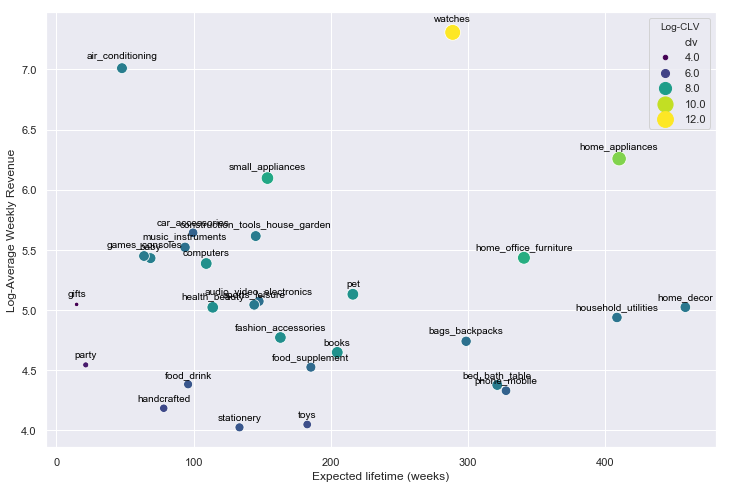

In [216]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=business_group,
                x='fitted', y='avg_weekly_revenue', 
                size='clv', hue='clv',
                sizes=(20,250), palette="viridis")
plt.ylabel("Log-Average Weekly Revenue")
plt.xlabel("Expected lifetime (weeks)")
plt.legend(title="Log-CLV")
for i in range(0,business_group.shape[0]):
     plt.text(business_group.fitted[i], 
              business_group.avg_weekly_revenue[i]*1.01,
              business_group.business_segment[i],
              horizontalalignment='center', verticalalignment='bottom',
              size='medium', color='black')

In [217]:
closed_clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 835
Data columns (total 7 columns):
seller_id                 380 non-null object
business_segment          380 non-null object
lead_type                 377 non-null object
clv                       380 non-null float64
lead_behaviour_profile    289 non-null object
fitted                    380 non-null float64
avg_weekly_revenue        380 non-null float64
dtypes: float64(3), object(4)
memory usage: 23.8+ KB


In [247]:
lead_group = closed_clv.groupby('lead_type').agg(np.mean).reset_index()
lead_group.clv = lead_group.clv.apply(np.log).round(2)
lead_group.avg_weekly_revenue = lead_group.avg_weekly_revenue.apply(np.log)

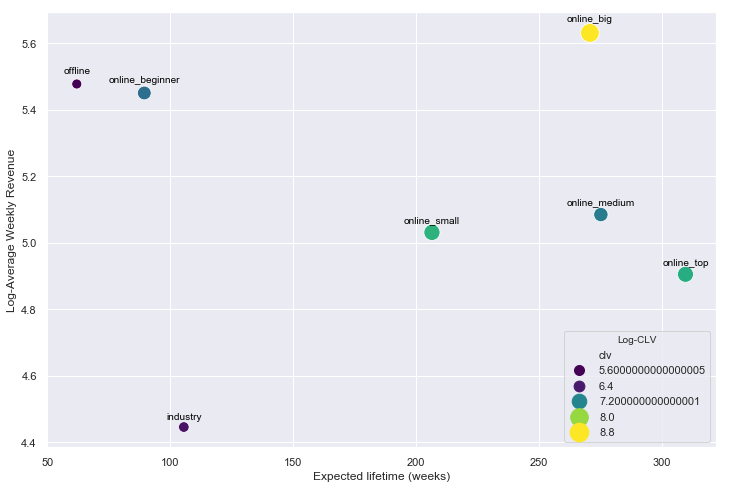

In [250]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=lead_group,
                x='fitted', y='avg_weekly_revenue', 
                size='clv', hue='clv', 
                palette='viridis', sizes=(100,350), legend="brief")
plt.ylabel("Log-Average Weekly Revenue")
plt.xlabel("Expected lifetime (weeks)")
plt.legend(title="Log-CLV")
for i in range(0,lead_group.shape[0]):
     plt.text(lead_group.fitted[i], 
              lead_group.avg_weekly_revenue[i]*1.01,
              lead_group.lead_type[i],
              horizontalalignment='center', verticalalignment='top',
              size='medium', color='black')

In [254]:
closed_clv.lead_behaviour_profile.value_counts()

cat           184
eagle          50
wolf           43
shark          10
cat, wolf       1
eagle, cat      1
Name: lead_behaviour_profile, dtype: int64

In [260]:
main_profiles = ['cat', 'eagle', 'wolf', 'shark']
behaviour_group = closed_clv.loc[closed_clv.lead_behaviour_profile.isin(main_profiles)]\
                            .groupby('lead_behaviour_profile')\
                            .agg(np.mean)
behaviour_group.round(2)

,clv,fitted,avg_weekly_revenue
lead_behaviour_profile,,,
cat,1637.50,171.82,176.95
eagle,2257.51,599.22,193.64
shark,5693.60,251.44,804.88
wolf,728.63,104.00,118.15
